## Import Toolkit

In [1]:
#OS libs
import os

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline



#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Warningds
import warnings
warnings.filterwarnings('ignore')

#Other
from tqdm import tqdm

2024-01-10 20:20:48.437478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 20:20:48.437620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 20:20:48.490448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 20:20:48.588382: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 20:20:49.916160: W tensorflow/compiler/tf2

## Load data

In [2]:
!pwd

/home/leonid/Desktop/mri_tumor_classification/leonid


In [3]:
# Train

train_data_path = '../data/Training/'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)


# Test

test_data_path = '../data/Testing/'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

## Split Data into Valid and Test

In [4]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

## Image Data Generator

In [5]:
img_size = (224, 224)
batch_size = 32
tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'grayscale' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'grayscale' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'grayscale' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Show sample from train data

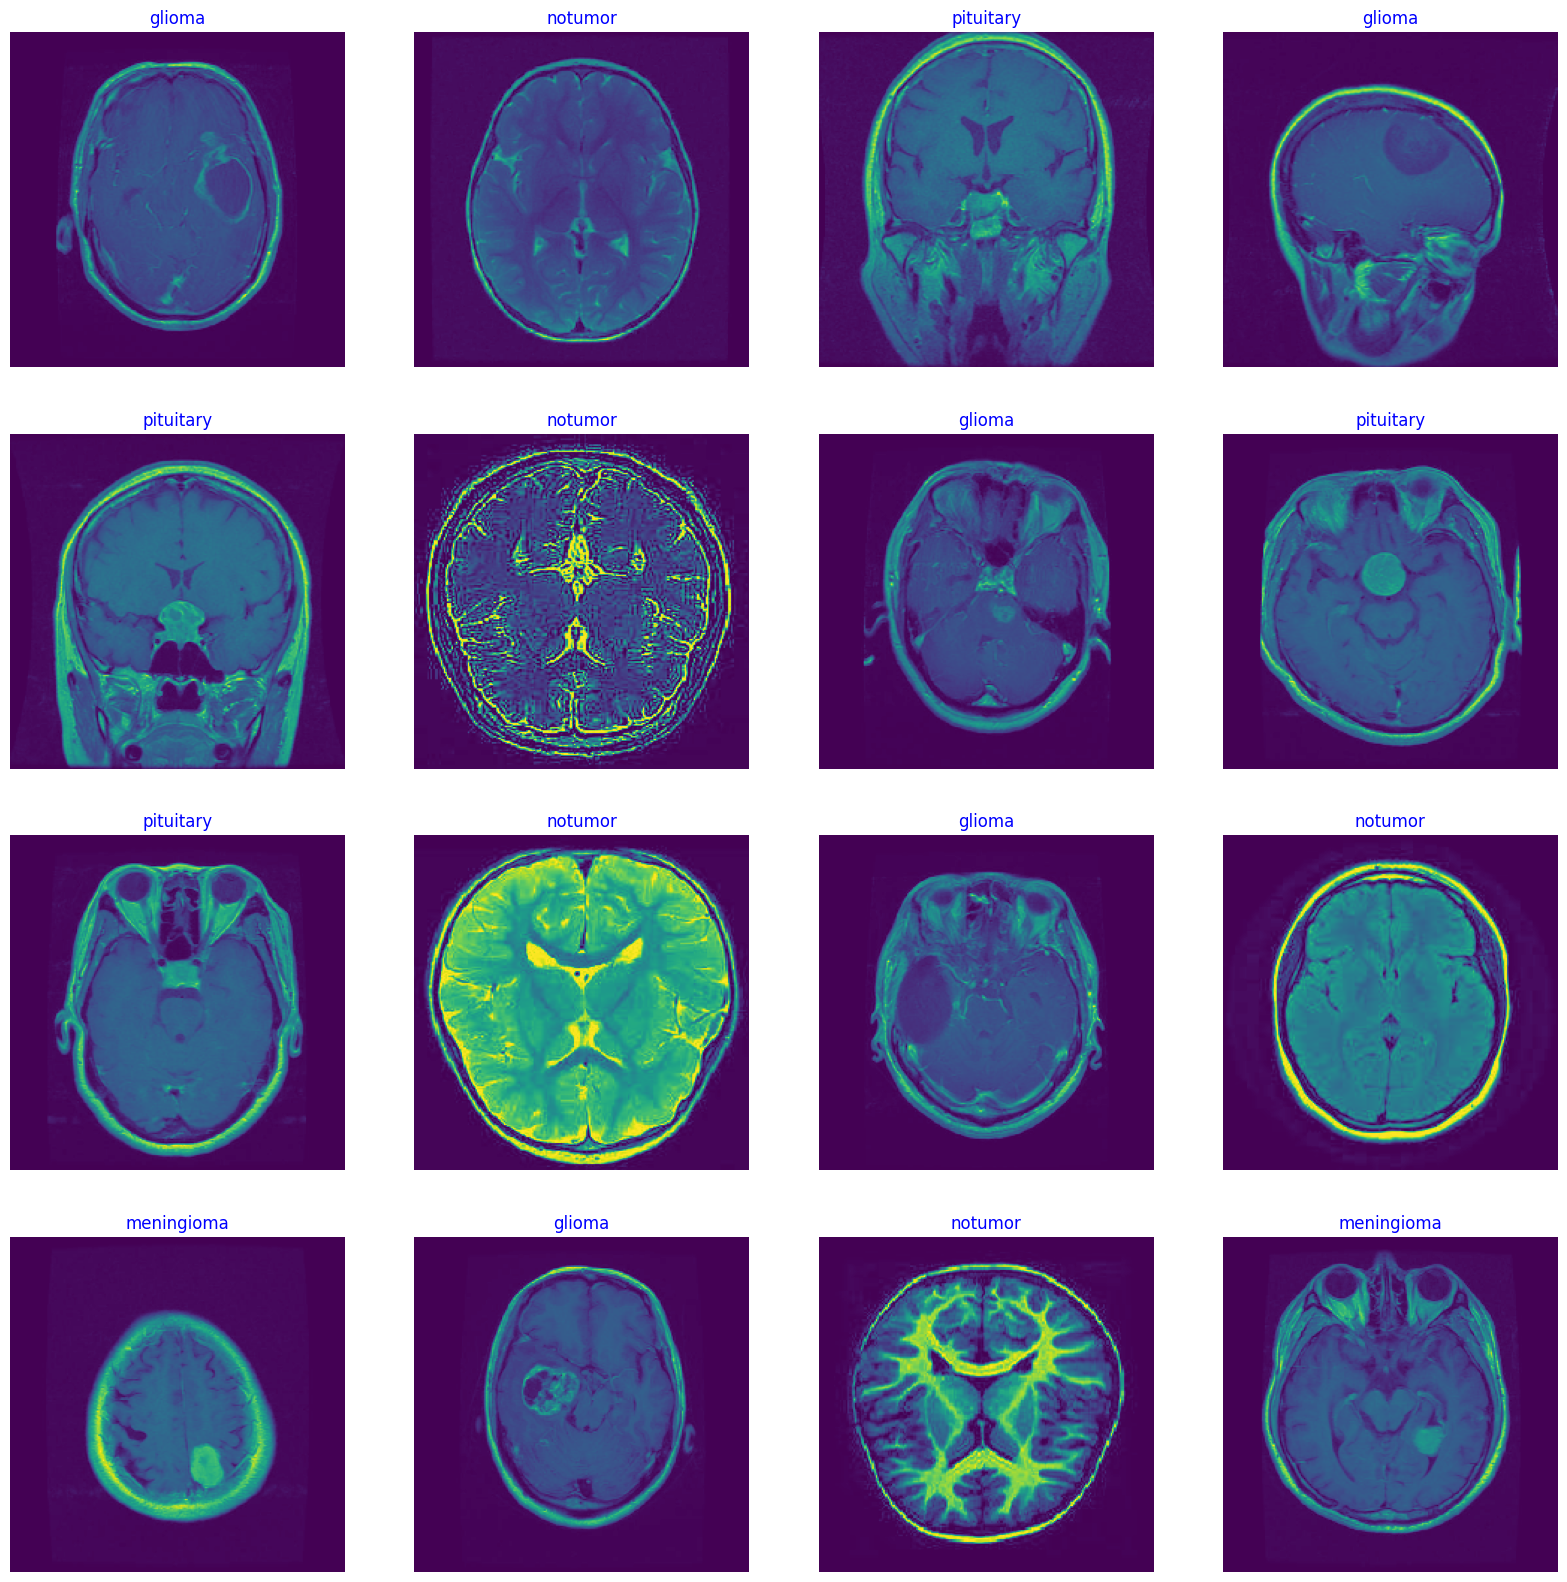

In [6]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

## Flatten images

In [7]:
# Training data
X_train, y_train = [], []
for i in tqdm(range(len(train_gen))):
    images, labels = train_gen[i]
    X_train.append(images.reshape(images.shape[0], -1))
    y_train.append(np.argmax(labels, axis=1))

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Validation data
X_valid, y_valid = [], []
for i in tqdm(range(len(valid_gen))):
    images, labels = valid_gen[i]
    X_valid.append(images.reshape(images.shape[0], -1))
    y_valid.append(np.argmax(labels, axis=1))

X_valid = np.concatenate(X_valid)
y_valid = np.concatenate(y_valid)

# Test data
X_test, y_test = [], []
for i in tqdm(range(len(test_gen))):
    images, labels = test_gen[i]
    X_test.append(images.reshape(images.shape[0], -1))
    y_test.append(np.argmax(labels, axis=1))

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

100%|██████████| 21/21 [00:01<00:00, 19.77it/s]


In [8]:
#check
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(5712, 50176) (5712,)
(655, 50176) (655,)
(656, 50176) (656,)


## PCA

In [9]:
from sklearn.decomposition import PCA

n_components = 2250

pca = make_pipeline(StandardScaler(), PCA(n_components=n_components, random_state=42))
X_train_pca = pca.fit_transform(X_train)


X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

print("Original shape:", X_train.shape, X_valid.shape, X_test.shape)
print("Reduced shape:", X_train_pca.shape, X_valid_pca.shape, X_test_pca.shape)


Original shape: (5712, 50176) (655, 50176) (656, 50176)
Reduced shape: (5712, 2250) (655, 2250) (656, 2250)


## Model Structure (SVM)

In [10]:
model_SVC = LinearSVC(max_iter=1000, random_state=42)
model_SVC.fit(X_train_pca, y_train)

LinearSVC(random_state=42)

In [11]:
# validation
y_valid_pred = model_SVC.predict(X_valid_pca)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)

print(f'Validation Accuracy: {accuracy_valid:.4f}')
print('Classification Report:')
print(classification_report(y_valid, y_valid_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_valid, y_valid_pred))


Validation Accuracy: 0.8992
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       149
           1       0.79      0.80      0.79       142
           2       0.97      0.98      0.97       206
           3       0.94      0.94      0.94       158

    accuracy                           0.90       655
   macro avg       0.89      0.89      0.89       655
weighted avg       0.90      0.90      0.90       655

Confusion Matrix:
[[126  19   0   4]
 [ 17 113   6   6]
 [  3   2 201   0]
 [  0   9   0 149]]


In [12]:
# test 
y_test_pred = model_SVC.predict(X_test_pca)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f'Test Accuracy: {accuracy_test:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_test_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))


Test Accuracy: 0.8765
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       151
           1       0.80      0.79      0.79       164
           2       0.96      0.96      0.96       199
           3       0.92      0.96      0.94       142

    accuracy                           0.88       656
   macro avg       0.87      0.87      0.87       656
weighted avg       0.88      0.88      0.88       656

Confusion Matrix:
[[118  27   2   4]
 [ 22 129   5   8]
 [  5   3 191   0]
 [  2   3   0 137]]


## Model Structure (OVR)

In [13]:
model_OVR = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
model_OVR.fit(X_train_pca, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42)

In [14]:
# validation
y_valid_pred = model_OVR.predict(X_valid_pca)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)

print(f'Validation Accuracy: {accuracy_valid:.4f}')
print('Classification Report:')
print(classification_report(y_valid, y_valid_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_valid, y_valid_pred))

Validation Accuracy: 0.9145
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       149
           1       0.81      0.80      0.81       142
           2       0.97      0.99      0.98       206
           3       0.96      0.97      0.97       158

    accuracy                           0.91       655
   macro avg       0.91      0.91      0.91       655
weighted avg       0.91      0.91      0.91       655

Confusion Matrix:
[[128  20   0   1]
 [ 17 114   6   5]
 [  0   2 204   0]
 [  0   5   0 153]]


In [15]:
# test 
y_test_pred = model_OVR.predict(X_test_pca)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f'Test Accuracy: {accuracy_test:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_test_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.9085
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       151
           1       0.84      0.83      0.83       164
           2       0.98      0.98      0.98       199
           3       0.94      0.98      0.96       142

    accuracy                           0.91       656
   macro avg       0.90      0.91      0.90       656
weighted avg       0.91      0.91      0.91       656

Confusion Matrix:
[[125  23   2   1]
 [ 17 136   3   8]
 [  1   2 196   0]
 [  2   1   0 139]]
